In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 1000

ng =11

ng_adju = (/ -2 , -2 /) 

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 200

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 340

data w_diffuse
     &     /1.8 , 1.8 , 1.8 , 1.8,
     &     1.8 , 1.8 , 1.5 , 1.5,
     &     1.5 , 1.5 , 1.5/

data wgt
     &     /0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

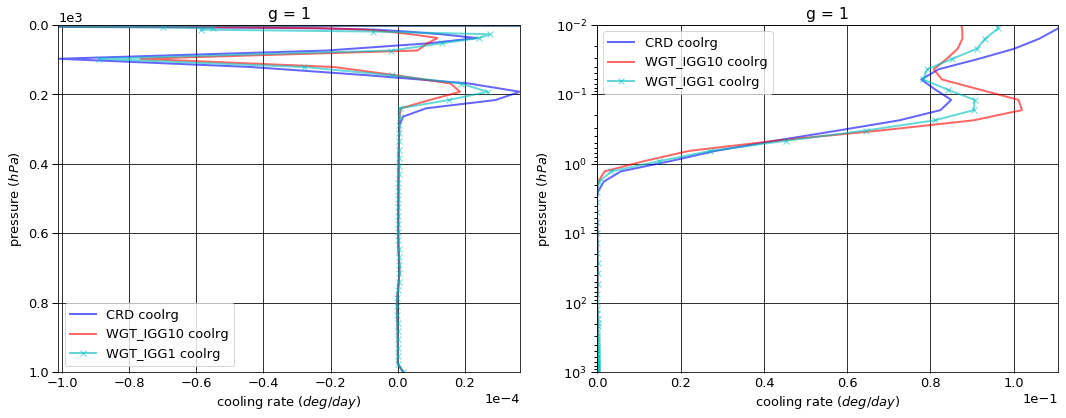

# Figure: cooling rate g-group 2

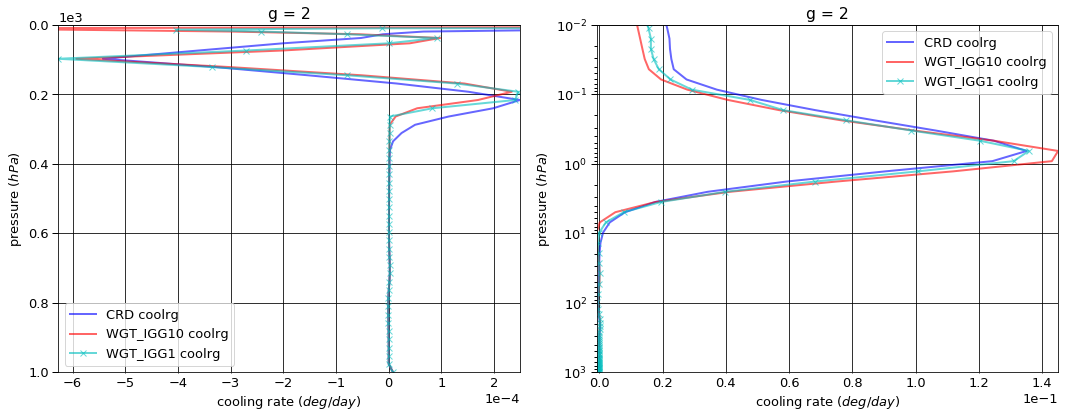

# Figure: cooling rate g-group 3

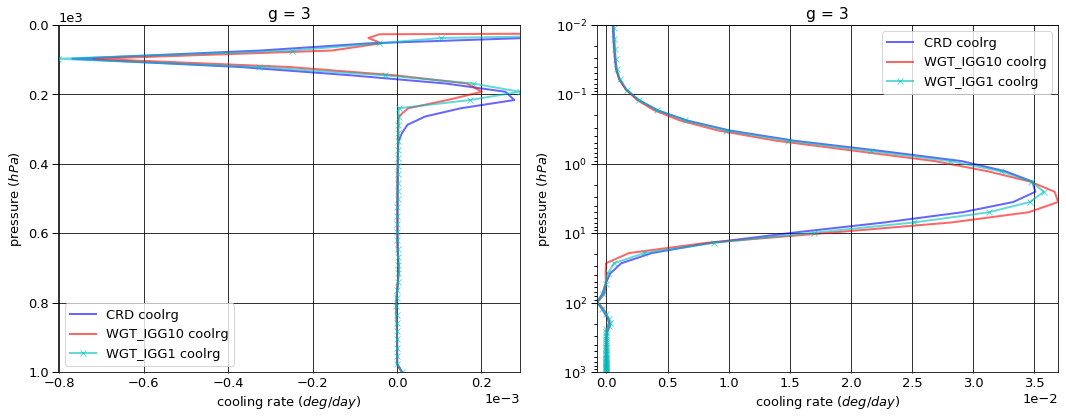

# Figure: cooling rate g-group 4

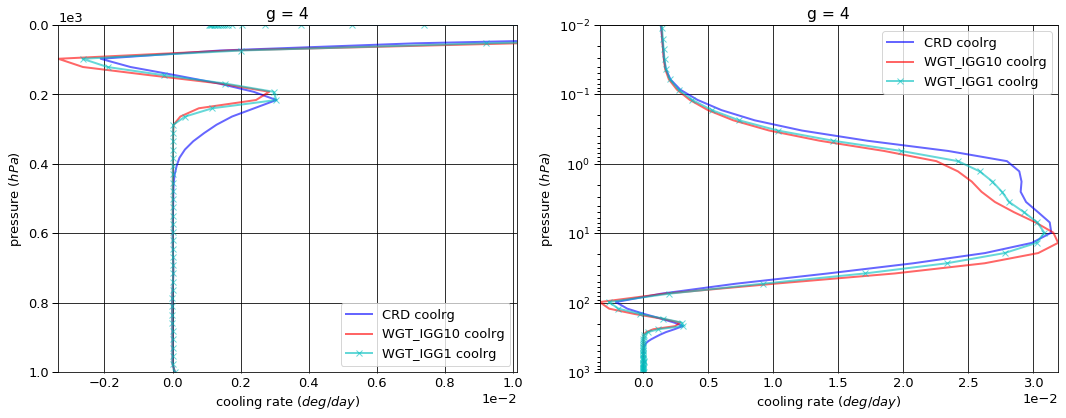

# Figure: cooling rate g-group 5

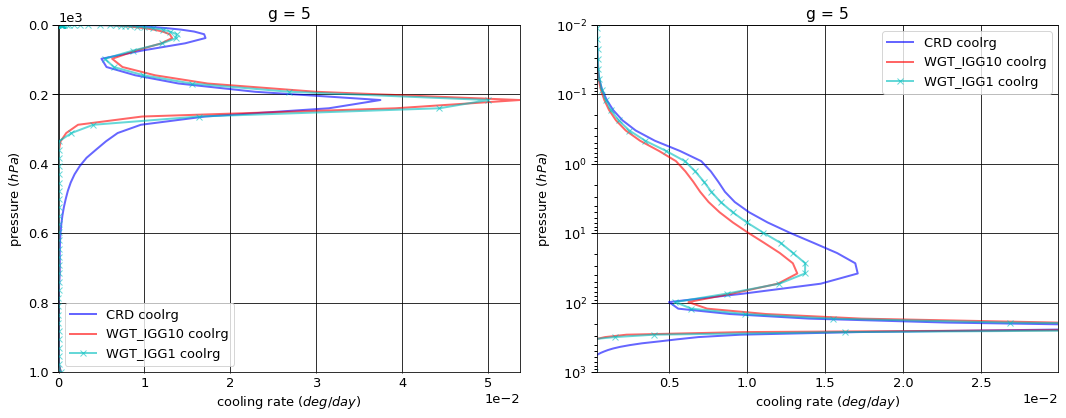

# Figure: cooling rate g-group 6

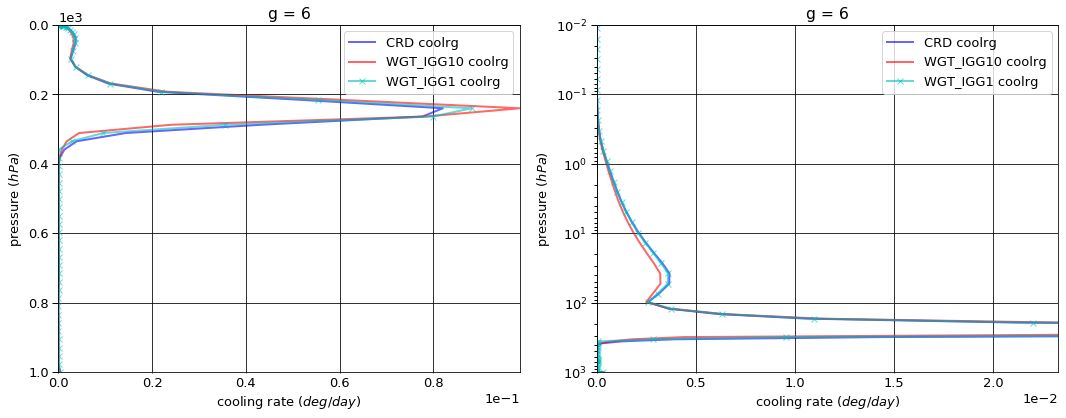

# Figure: cooling rate g-group 7

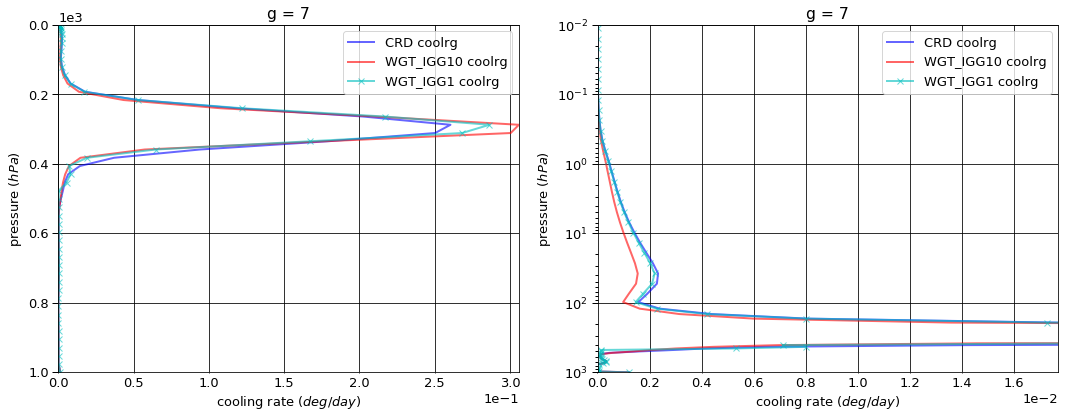

# Figure: cooling rate g-group 8

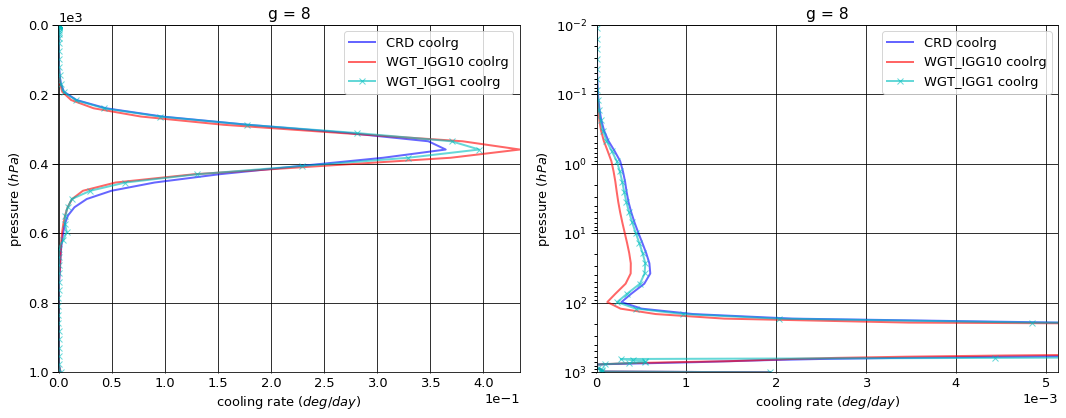

# Figure: cooling rate g-group 9

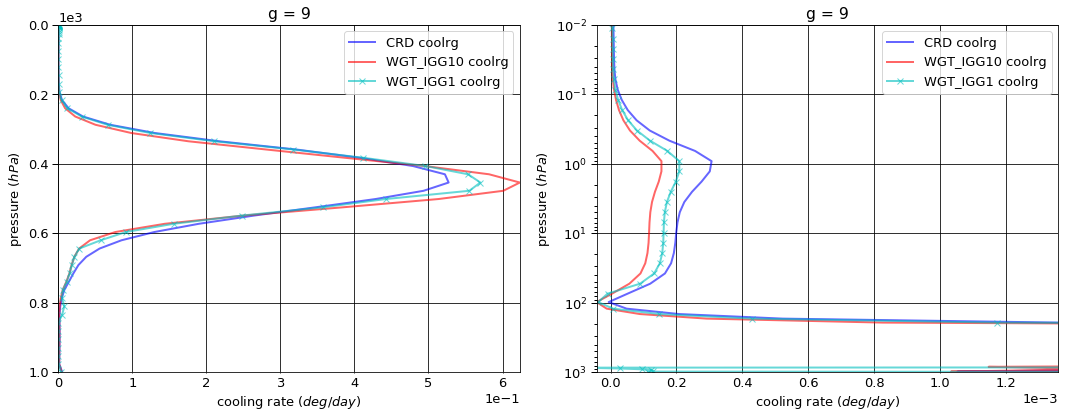

# Figure: cooling rate g-group 10

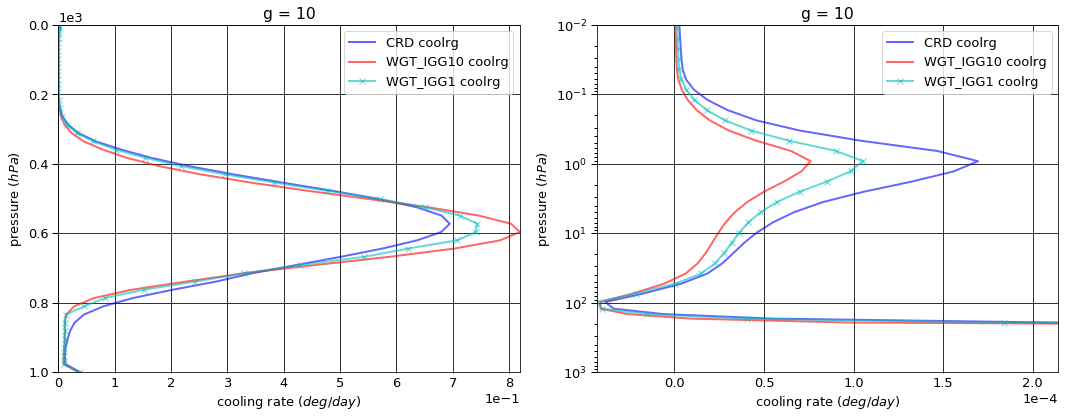

# Figure: cooling rate g-group 11

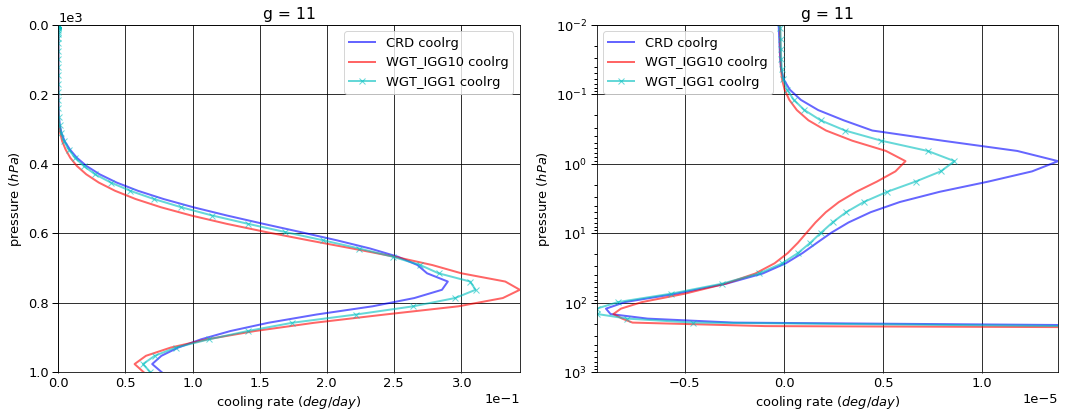

# Figure: cooling rate g-group total

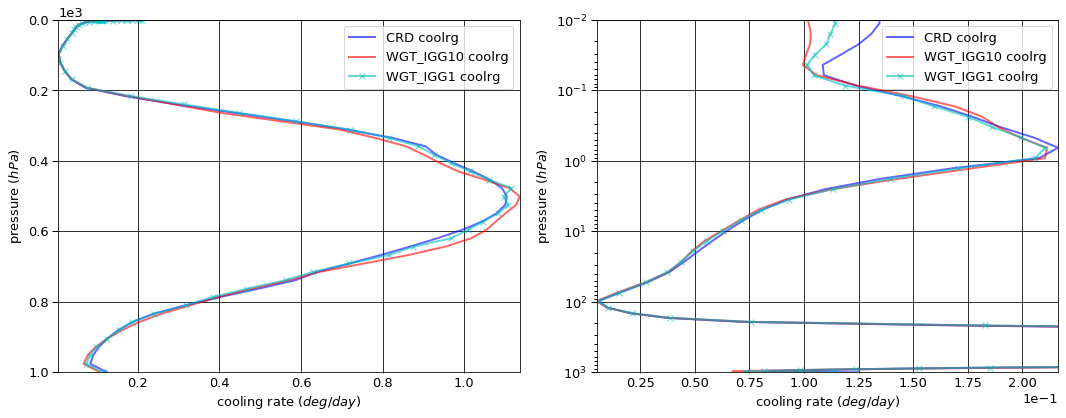

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005802   0.000000  -0.005802
   1013.0   76     -0.009730   0.009726  -0.000005
2  0.0      1      -0.029530   0.000000  -0.029530
   1013.0   76     -0.044436   0.044412  -0.000024
3  0.0      1      -0.039922   0.000000  -0.039922
   1013.0   76     -0.067355   0.067321  -0.000034
4  0.0      1      -0.171348   0.000000  -0.171348
   1013.0   76     -0.365879   0.365691  -0.000189
5  0.0      1      -0.650457   0.000000  -0.650457
   1013.0   76     -1.429126   1.428356  -0.000769
6  0.0      1      -0.934307   0.000000  -0.934307
   1013.0   76     -1.885778   1.884820  -0.000958
7  0.0      1      -3.574376   0.000000  -3.574376
   1013.0   76     -6.479185   6.475840  -0.003345
8  0.0      1      -6.289929   0.000000  -6.289929
   1013.0   76    -10.308642  10.303262  -0.005380
9  0.0      1     -13.681956   0.000000 -13.681956
   1013.0   76    -20.135346  20.121885  -0.013462
10 0.0      1     -23.910494   0.000000 -23.910494
   1013.0   76    -31.540371  31.430272  -0.110099
11 0.0      1     -11.846047   0.000000 -11.846047
   1013.0   76    -14.209382  13.718004  -0.491377


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005641   0.000000  -0.005641
   1013.0   76     -0.009730   0.009726  -0.000005
2  0.0      1      -0.030714   0.000000  -0.030714
   1013.0   76     -0.044436   0.044412  -0.000024
3  0.0      1      -0.040809   0.000000  -0.040809
   1013.0   76     -0.067355   0.067321  -0.000034
4  0.0      1      -0.165326   0.000000  -0.165326
   1013.0   76     -0.365879   0.365691  -0.000189
5  0.0      1      -0.616120   0.000000  -0.616120
   1013.0   76     -1.429126   1.428386  -0.000739
6  0.0      1      -0.922005   0.000000  -0.922005
   1013.0   76     -1.885778   1.884820  -0.000958
7  0.0      1      -3.575284   0.000000  -3.575284
   1013.0   76     -6.479185   6.475840  -0.003345
8  0.0      1      -6.289731   0.000000  -6.289731
   1013.0   76    -10.308642  10.303262  -0.005380
9  0.0      1     -13.698478   0.000000 -13.698478
   1013.0   76    -20.135346  20.123500  -0.011846
10 0.0      1     -24.018853   0.000000 -24.018853
   1013.0   76    -31.540371  31.448214  -0.092157
11 0.0      1     -11.946747   0.000000 -11.946747
   1013.0   76    -14.209382  13.930889  -0.278492


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005732   0.000000  -0.005732
   1013.0   76     -0.009730   0.009726  -0.000005
2  0.0      1      -0.030284   0.000000  -0.030284
   1013.0   76     -0.044436   0.044412  -0.000024
3  0.0      1      -0.040404   0.000000  -0.040404
   1013.0   76     -0.067355   0.067321  -0.000034
4  0.0      1      -0.164651   0.000000  -0.164651
   1013.0   76     -0.365879   0.365691  -0.000189
5  0.0      1      -0.624908   0.000000  -0.624908
   1013.0   76     -1.429126   1.428386  -0.000739
6  0.0      1      -0.927995   0.000000  -0.927995
   1013.0   76     -1.885778   1.884820  -0.000958
7  0.0      1      -3.551932   0.000000  -3.551932
   1013.0   76     -6.479185   6.475840  -0.003345
8  0.0      1      -6.254627   0.000000  -6.254627
   1013.0   76    -10.308642  10.303262  -0.005380
9  0.0      1     -13.614566   0.000000 -13.614566
   1013.0   76    -20.135346  20.124559  -0.010787
10 0.0      1     -23.855748   0.000000 -23.855748
   1013.0   76    -31.540371  31.439750  -0.100620
11 0.0      1     -11.863693   0.000000 -11.863693
   1013.0   76    -14.209382  13.887312  -0.322070


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.611669e-04  0.000000  1.611669e-04
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
2  0.0      1     -1.183157e-03  0.000000 -1.183157e-03
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
3  0.0      1     -8.871240e-04  0.000000 -8.871240e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1      6.022190e-03  0.000000  6.022190e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      3.433724e-02  0.000000  3.433724e-02
   1013.0   76     0.000000e+00  0.000030  3.014534e-05
6  0.0      1      1.230179e-02  0.000000  1.230179e-02
   1013.0   76     0.000000e+00  0.000000  1.084202e-19
7  0.0      1     -9.080000e-04  0.000000 -9.080000e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      1.976000e-04  0.000000  1.976000e-04
   1013.0   76    -1.776357e-15  0.000000  0.000000e+00
9  0.0      1     -1.652200e-02  0.000000 -1.652200e-02
   1013.0   76     0.000000e+00  0.001615  1.615558e-03
10 0.0      1     -1.083590e-01  0.000000 -1.083590e-01
   1013.0   76     0.000000e+00  0.017942  1.794194e-02
11 0.0      1     -1.007000e-01  0.000000 -1.007000e-01
   1013.0   76     0.000000e+00  0.212885  2.128850e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      7.046580e-05  0.000000  7.046580e-05
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
2  0.0      1     -7.534660e-04  0.000000 -7.534660e-04
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
3  0.0      1     -4.818390e-04  0.000000 -4.818390e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
4  0.0      1      6.696940e-03  0.000000  6.696940e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1      2.554862e-02  0.000000  2.554862e-02
   1013.0   76     0.000000e+00  0.000030  3.014534e-05
6  0.0      1      6.311760e-03  0.000000  6.311760e-03
   1013.0   76     0.000000e+00  0.000000  1.084202e-19
7  0.0      1      2.244430e-02  0.000000  2.244430e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      3.530170e-02  0.000000  3.530170e-02
   1013.0   76    -1.776357e-15  0.000000  0.000000e+00
9  0.0      1      6.739000e-02  0.000000  6.739000e-02
   1013.0   76     0.000000e+00  0.002674  2.674553e-03
10 0.0      1      5.474600e-02  0.000000  5.474600e-02
   1013.0   76     0.000000e+00  0.009478  9.478550e-03
11 0.0      1     -1.764600e-02  0.000000 -1.764600e-02
   1013.0   76     0.000000e+00  0.169308  1.693073e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.043731e-01
   1001.112500 75     1.719354e-06
2  0.000312    1      1.387557e-02
   1001.112500 75     8.551406e-06
3  0.000312    1      2.984716e-04
   1001.112500 75     1.229485e-05
4  0.000312    1      9.406748e-04
   1001.112500 75     6.792873e-05
5  0.000312    1      2.423731e-04
   1001.112500 75     2.777113e-04
6  0.000312    1      1.431403e-06
   1001.112500 75     3.446745e-04
7  0.000312    1      4.342970e-06
   1001.112500 75     1.202789e-03
8  0.000312    1      5.077911e-06
   1001.112500 75     1.934359e-03
9  0.000312    1      5.220544e-06
   1001.112500 75     5.204059e-03
10 0.000312    1      4.993470e-07
   1001.112500 75     3.894223e-02
11 0.000312    1     -4.101024e-07
   1001.112500 75     7.715877e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      7.123763e-02
   1001.112500 75     1.719354e-06
2  0.000312    1      6.515066e-03
   1001.112500 75     8.551406e-06
3  0.000312    1      3.688461e-04
   1001.112500 75     1.229485e-05
4  0.000312    1      1.052519e-03
   1001.112500 75     6.792873e-05
5  0.000312    1      2.703970e-04
   1001.112500 75     2.657810e-04
6  0.000312    1      1.285066e-06
   1001.112500 75     3.446745e-04
7  0.000312    1      3.035589e-06
   1001.112500 75     1.202789e-03
8  0.000312    1      2.605192e-06
   1001.112500 75     1.934359e-03
9  0.000312    1      2.194610e-06
   1001.112500 75     4.686036e-03
10 0.000312    1     -4.034259e-07
   1001.112500 75     3.558578e-02
11 0.000312    1     -2.588237e-07
   1001.112500 75     6.369784e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      8.415603e-02
   1001.112500 75     1.719354e-06
2  0.000312    1      9.480459e-03
   1001.112500 75     8.551406e-06
3  0.000312    1      3.677773e-04
   1001.112500 75     1.229485e-05
4  0.000312    1      1.069843e-03
   1001.112500 75     6.792873e-05
5  0.000312    1      2.981282e-04
   1001.112500 75     2.657810e-04
6  0.000312    1      1.485998e-06
   1001.112500 75     3.446745e-04
7  0.000312    1      4.408841e-06
   1001.112500 75     1.202789e-03
8  0.000312    1      3.876676e-06
   1001.112500 75     1.934359e-03
9  0.000312    1      3.409258e-06
   1001.112500 75     3.877805e-03
10 0.000312    1      1.806987e-07
   1001.112500 75     3.793018e-02
11 0.000312    1     -2.711921e-07
   1001.112500 75     6.866908e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.313545e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -7.360504e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      7.037443e-05
   1001.112500 75    -1.694066e-21
4  0.000312    1      1.118446e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      2.802397e-05
   1001.112500 75    -1.193023e-05
6  0.000312    1     -1.463373e-07
   1001.112500 75     5.421011e-20
7  0.000312    1     -1.307381e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -2.472719e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -3.025934e-06
   1001.112500 75    -5.180228e-04
10 0.000312    1     -9.027728e-07
   1001.112500 75    -3.356453e-03
11 0.000312    1      1.512787e-07
   1001.112500 75    -1.346094e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.021705e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.395111e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      6.930566e-05
   1001.112500 75    -1.694066e-21
4  0.000312    1      1.291677e-04
   1001.112500 75     0.000000e+00
5  0.000312    1      5.575515e-05
   1001.112500 75    -1.193023e-05
6  0.000312    1      5.459510e-08
   1001.112500 75     5.421011e-20
7  0.000312    1      6.587070e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.201235e-06
   1001.112500 75     0.000000e+00
9  0.000312    1     -1.811285e-06
   1001.112500 75    -1.326254e-03
10 0.000312    1     -3.186483e-07
   1001.112500 75    -1.012051e-03
11 0.000312    1      1.389103e-07
   1001.112500 75    -8.489697e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.134168,0.000000,-61.134168
1013.0,76,-86.475231,85.849588,-0.625642



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-61.309708,0.00000,-61.309708
1013.0,76,-86.475231,86.08206,-0.393169



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.934540,0.000000,-60.934540
1013.0,76,-86.475231,86.031078,-0.444151



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.755393e-01,0.000000,-0.175539
1013.0,76,-1.421085e-14,0.232472,0.232473



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.996285e-01,0.00000,0.199628
1013.0,76,-1.421085e-14,0.18149,0.181491


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.119746
1001.112500,75,0.125155



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.079453
1001.112500,75,0.107808



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.095385
1001.112500,75,0.114315



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.040293
1001.112500,75,-0.017347



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.024361
1001.112500,75,-0.010840


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
